#### Wprowadzenie

Pomimo ogromnych sukcesów, jakie metody uczenia głębokiego osiągnęły w czasie ostatnich kilkunastu
lat w zagadnieniach dotyczących widzenia maszynowego i przetwarzania języka naturalnego, w przypadku
(prawdpodobnie najpowszechniejszego) zagadnienia uczenia tabelarycznego, ich przewaga nad
klasycznymi algorytmami takimi jak lasy losowe, czy Gradient Boosted Decision Trees (GBDT) wcale nie
jest oczywista. Co więcej, patrząc na typowo wykorzystywane metody w praktyce, czy na modele
osiągające najlepsze wyniki w konkursach przeprowadzanych np. na *Kaggle*, możnaby pokusić się o
wniosek przeciwny -- dla danych tabelarycznych to metody klasyczne mają widoczną przewagę na
modelami neuronowymi.

W artykule Grinsztajna i in. [1] przedstawiono obszerne wyniki eksperymentalne, które zdają się
potwierdzać przewagę modeli klasycznych opartych na drzewach decyzyjnych nad prostymi sieciami w
pełni połączonymi. Autorzy przeprowadzili obszerne eksperymenty na kolekcji 45 różnych
tabelarycznych zbiorów danych, które są według nich reprezentatywne dla tych typowo spotykanych.
Wśród tej kolekcji wyróżnili oni następujące 4 klasy: zagadnienia klasyfikacji na cechach
numerycznych, zagadnienia klasyfikacji na cechach mieszanych, zagadnienia regresji na cechach
numerycznych oraz zagadnienia regresji na cechach mieszanych. Dla tych czterech klas porównali oni
efektywność modeli drzewiastych (XGBoost, RandomForest, GradientBoostingTree oraz
HistGradientBoostingTree z biblioteki Scikit-learn) i modeli neuronowych (MLP, Resnet,
FTTransformer, SAINT)

[1] Léo Grinsztajn, Edouard Oyallon, & Gaël Varoquaux. (2022). Why do tree-based models still
    outperform deep learning on tabular data?. https://arxiv.org/pdf/2207.08815

[2] Yury Gorishniy, Ivan Rubachev, & Artem Babenko. (2023). On Embeddings for Numerical Features in
    Tabular Deep Learning. https://arxiv.org/pdf/2203.05556

In [ ]:
datasets = {
    "electricity": 44120,
    "covertype": 44121,
    "pol": 44122,
    "house_16H": 44123,
    "kdd": 44124,
    "MagicTelescope": 44125,
    "bank_marketing": 44126,
    "phoneme": 44127,
    "miniboone": 44128,
    "higgs": 44129,
    "eye_movements": 44130,
    "jannis": 44131,
    "credit": 44089,
    "california": 44090,
}

In [ ]:
import time
import logging

logger = logging.getLogger()
logging.basicConfig(
    filename=f"logs/experiment_{time.strftime('%Y%m%d-%H%M%S')}.log",
    format="%(asctime)s:%(levelname)s:%(message)s",
    encoding="utf-8",
    filemode="w",
    force=True,
    level=logging.DEBUG,
)

In [ ]:
from warnings import simplefilter
from collections import defaultdict

random_state = 0
n_splits = 10
results = defaultdict(list)
simplefilter("ignore", UserWarning)

In [ ]:
import pickle
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer

from qmlp import QMLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier


for dataset, data_id in datasets.items():
    X: pd.DataFrame
    y: pd.DataFrame
    X, y = fetch_openml(data_id=data_id, return_X_y=True, as_frame=True)

    logger.info(f"{dataset=} | size = {X.shape} | #NaN = {X.isna().sum().sum()}\n" + "=" * 100)

    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold_idx, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        logger.info(f"Fold {fold_idx}:\n" + "-" * 100)

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clfs = {
            "LogisticRegression": make_pipeline(
                QuantileTransformer(output_distribution="normal", random_state=random_state),
                LogisticRegression(max_iter=1_000, random_state=random_state),
            ),
            "RandomForestClassifier": RandomForestClassifier(random_state=random_state),
            "HistGradientBoostingClassifier": HistGradientBoostingClassifier(random_state=random_state),
            "MLPWithRawFeatures": make_pipeline(
                QuantileTransformer(output_distribution="normal", random_state=random_state),
                QMLPClassifier(dropout=0.2, use_quantile_encoding=False, random_state=random_state),
            ),
            "MLPWithQuantilePLEEncoding": QMLPClassifier(use_quantile_encoding=True, random_state=random_state),
            "MLPWithQuantileOrdinalEncoding": make_pipeline(
                KBinsDiscretizer(n_bins=48, encode="ordinal", strategy="quantile", random_state=random_state),
                QMLPClassifier(dropout=0.2, use_quantile_encoding=False, random_state=random_state),
            ),
        }

        try:
            for clf_name, clf in clfs.items():
                t = time.perf_counter()
                clf.fit(X_train, y_train)
                t = time.perf_counter() - t
                acc = accuracy_score(y_test, clf.predict(X_test))

                results[dataset, clf_name, "fit_times"].append(t)
                results[dataset, clf_name, "test_acc_scores"].append(acc)

                logger.info(f"{clf_name:>30s} | TEST ACC. {acc:.2%} | FIT TIME {t:.3f}s")

            fname = f"results/checkpoints/{time.strftime('%Y%m%d-%H%M%S')}_{dataset}_{fold_idx}.pickle"
            with open(fname, "wb") as file:
                pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

        except Exception as e:
            logger.error(f"Exception at {dataset=}, {fold_idx=}: {e}")

logger.handlers.clear()

with open(f"results/results_{time.strftime('%Y%m%d-%H%M%S')}.pickle", "wb") as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

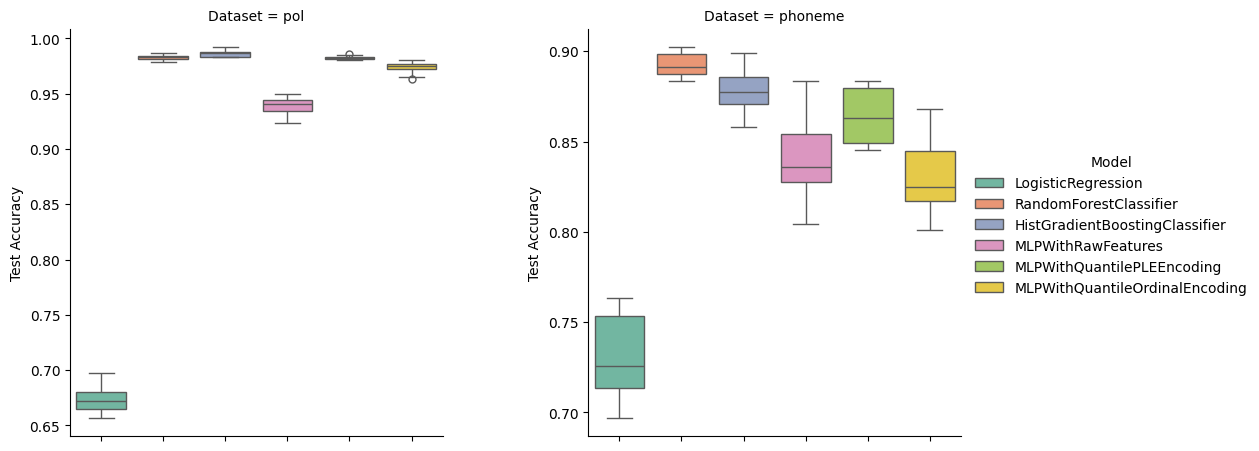

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

with open(f"results/results_20250505-163546.pickle", "rb") as file:
    df = pd.DataFrame(pickle.load(file))

df_melt = df.xs(key="test_acc_scores", axis=1, level=2).melt()
df_melt.columns = ["Dataset", "Model", "Accuracy"]

g = sns.catplot(
    data=df_melt,
    x="Model",
    y="Accuracy",
    hue="Model",
    col="Dataset",
    kind="box",
    legend="full",
    legend_out=True,
    col_wrap=2,
    sharey=False,
    palette="Set2",
)

for ax in g.axes.flatten():
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("Test Accuracy")
plt.show()